2.3.3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta     

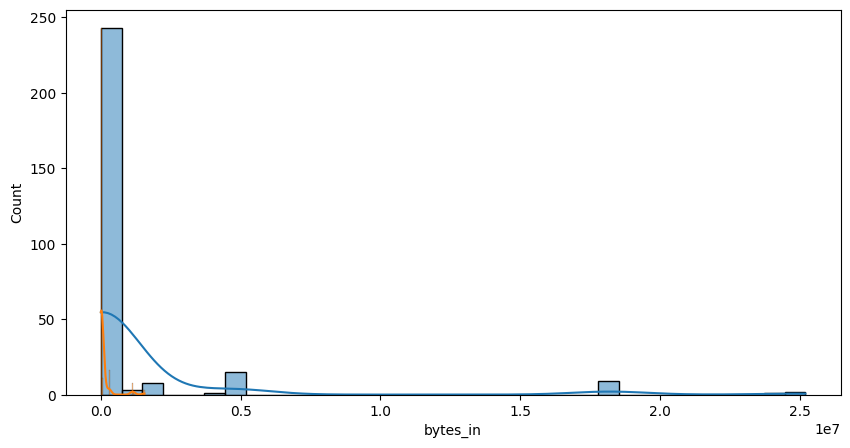

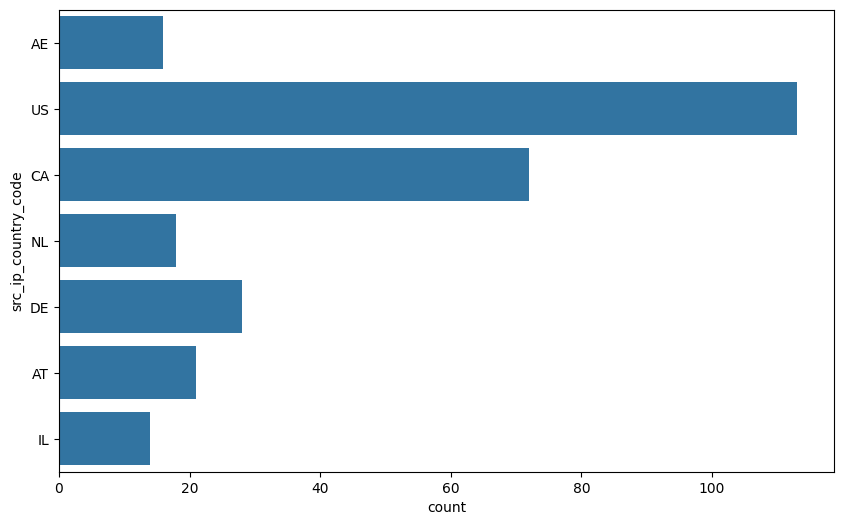

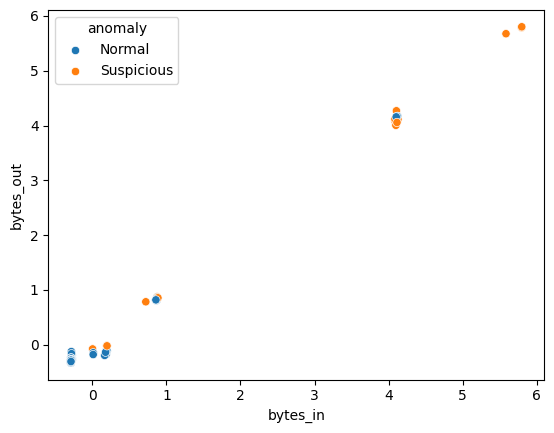

Epoch 1/10


c:\Users\nandh\OneDrive\Desktop\cybersecurity\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\nandh\OneDrive\Desktop\cybersecurity\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8579 - loss: 0.8869  
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8782 - loss: 0.8310 
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.7795 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.7284 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8782 - loss: 0.6793 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8782 - loss: 0.6283 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9492 - loss: 0.5842 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9492 - loss: 0.5470 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9949 - loss: 0.5107 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.4778 


In [13]:
import pandas as pd
print(pd.__version__)


df = pd.read_csv("../data/CloudWatch_Traffic_Web_Attack.csv")

df.head()
# Remove duplicates
df = df.drop_duplicates()

# Convert time columns
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Standardize country code
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

df.info()
# Session duration
df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# Average packet size
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['duration_seconds']

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['bytes_in'], kde=True)
sns.histplot(df['bytes_out'], kde=True)
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(y=df['src_ip_country_code'])
plt.show()
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
df[['bytes_in', 'bytes_out', 'duration_seconds']] = scaler.fit_transform(
    df[['bytes_in', 'bytes_out', 'duration_seconds']]
)

encoder = OneHotEncoder(sparse_output=False)
country_encoded = encoder.fit_transform(df[['src_ip_country_code']])
from sklearn.preprocessing import OneHotEncoder
import sklearn

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(sparse_output=False)
else:
    encoder = OneHotEncoder(sparse=False)

country_encoded = encoder.fit_transform(df[['src_ip_country_code']])
encoded_df = pd.DataFrame(
    country_encoded,
    columns=encoder.get_feature_names_out(['src_ip_country_code'])
)

df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
from sklearn.ensemble import IsolationForest

features = df[['bytes_in', 'bytes_out', 'duration_seconds']]

model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)

df['anomaly'] = df['anomaly'].map({-1: 'Suspicious', 1: 'Normal'})
df['anomaly'].value_counts()
sns.scatterplot(
    x=df['bytes_in'],
    y=df['bytes_out'],
    hue=df['anomaly']
)
plt.show()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

X = df[['bytes_in', 'bytes_out', 'duration_seconds']]
y = df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train[['bytes_in','bytes_out']], y_train, epochs=10)
